In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd

import difflib
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
sys.path.append('../AJA')
import AJA as aja

/Users/alicegorge/INF554/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import StandardScaler

def calculate_similarity(text, neighbors, df):
    max_similarity = 0.0
    if isinstance(neighbors, list):
        for neighbor in neighbors:
            if neighbor != []:
                if isinstance(neighbor, int):
                    neighbor_index = neighbor
                else:
                    neighbor_index = neighbor[0]
                neighbor_text = df.iloc[neighbor_index]['text']
                matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
                similarity = matcher.ratio()
                max_similarity = max(max_similarity, similarity)
    elif isinstance(neighbors, int):
        # Handle the case where 'neighbors' is an integer directly
        neighbor_index = neighbors
        neighbor_text = df.iloc[neighbor_index]['text']
        matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
        max_similarity = matcher.ratio()
    return max_similarity

def f(df_nodes, df_edges):

    df = df_nodes

    scaler = StandardScaler()

    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker')
    df = df.drop('speaker_int', axis=1)
    df = df.drop('speaker_text', axis=1)
    df = pd.concat([df, one_hot_encoded], axis=1)
    
    # TFIDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
    df['min_tfidf'] = tfidf_matrix.min(axis=1).toarray().flatten()
    df['min_tfidf'] = scaler.fit_transform(df['min_tfidf'].values.reshape(-1, 1))
    
    #Text analysis
    df['nb_occurences'] = df['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
    df['nb_occurences'] = scaler.fit_transform(df['nb_occurences'].values.reshape(-1,1))
    
    df['nb_words_more_7'] = df['text'].apply(lambda x: sum(len(mot) > 7 and mot.lower() != '<vocalsound>' for mot in x.split()))
    df['nb_words_more_7'] = scaler.fit_transform(df['nb_words_more_7'].values.reshape(-1,1))
    
    # Calcul de la colonne 'neighb'
    df_edges_grouped = df_edges.groupby(['transcription', 'start'])['end'].apply(list).reset_index()
    df = pd.merge(df, df_edges_grouped, how='left', left_on=['transcription', 'line'], right_on=['transcription', 'start'])
    df = df.rename(columns={'end': 'neighb'})

    # Calcul de la colonne 'similarities'
    df['similarities'] = df.apply(lambda row: calculate_similarity(row['text'], row['neighb'],df), axis=1)
    df['similarities'] = scaler.fit_transform(df['similarities'].values.reshape(-1,1))

    # Calcul de la colonne 'nb_neighb'
    df['nb_neighb'] = df['neighb'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df['nb_neighb'] = scaler.fit_transform(df['nb_neighb'].values.reshape(-1, 1))

    df = df.drop(['text','start', 'neighb'], axis=1)
                    
    return df

def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [3]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.2)

In [4]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [5]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.threshold = 0.5
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dropout = nn.Dropout(0.02956182281427211)  # Couche de dropout 
        self.dense1 = nn.Linear(20,1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        return x

    def set_threshold(self, t):
        self.threshold = t

    def predict(self, graph): #version sans threshold
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
        return np.array((logits > 0.5).int()).flatten()
    
    '''def predict(self, graph): #version avec threshold
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
            predictions = torch.sigmoid(logits)
        return np.array((predictions > self.threshold).int()).flatten()'''

In [6]:
# Charger l'extension autoreload
%load_ext autoreload

# Configurer autoreload pour recharger tous les modules avant l'exécution de chaque cellule
%autoreload 2

In [7]:
N_features = train_graphs['ES2002a'].x.shape[1]
N_features

390

In [8]:
# Move the instantiation of the model outside the training loop
model = NodeClassifier(32, N_features)
#model.set_threshold(0.59)
model_name='test'

# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use DataLoader to create batches of data
#train_loader = DataLoader(list(train_graphs.values()), batch_size=1, shuffle=True)
#N_train = len(train_loader)

train_loader = DataLoader(list(train_graphs.values()) + list(validation_graphs.values()), batch_size=1, shuffle=False)
N_train = len(train_loader)

validation_loader = DataLoader(list(validation_graphs.values()), batch_size=1, shuffle=False)
N_validation = len(validation_loader)

# Define the loss function and optimizer
alpha = 0.15730642604852357
gamma = 9.760602307411109
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.002272131994333311)

from sklearn.metrics import f1_score

# Train the model
best_f1_score = 0
for epoch in range(3):
    print('- Epoch', f'{epoch:03d}', '-')

    # training
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / N_train
    print('Loss:', f'{average_loss:.4f}')    

    # Evaluate the model on the training set

    model.eval()
    f1_moyen_train = 0
    for data in train_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_train += f1
    f1_moyen_train /= N_train
    print('F1 train:', f1_moyen_train)

    # Evaluate the model on the validation set
    model.eval()
    f1_moyen_valid = 0
    for data in validation_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_valid += f1
    f1_moyen_valid /= N_validation
    print('F1 valid:', f1_moyen_valid)

    # callbacks ou autre
    if f1_moyen_valid > best_f1_score:
        torch.save(model.state_dict(), "training_states/" + model_name + "-best.pth")
    else:
        optimizer.param_groups[0]['lr'] /= 2
        print('Learning rate reduced to:', optimizer.param_groups[0]['lr'])
    print('')

model.load_state_dict(torch.load("training_states/" + model_name + "-best.pth"))

- Epoch 000 -
Loss: 0.8477
F1 train: 0.5648616848459262
F1 valid: 0.5870692280555174

- Epoch 001 -
Loss: 0.7653
F1 train: 0.5770290060701599
F1 valid: 0.6010289687373077

- Epoch 002 -
Loss: 0.7433
F1 train: 0.5905178454573431
F1 valid: 0.6186642208050149



<All keys matched successfully>

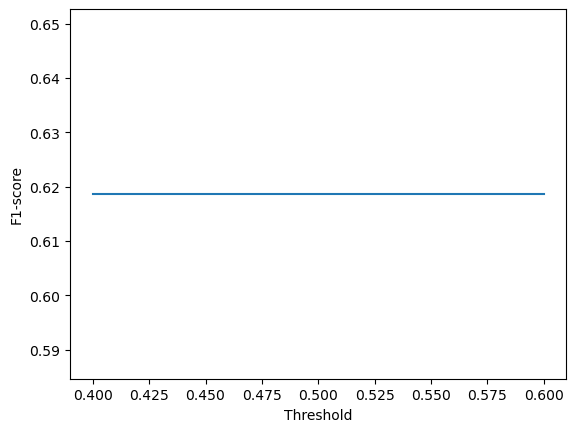

In [9]:
T = np.linspace(0.4,0.6,10)
f1s = []
for t in T:
    model.set_threshold(t)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    f1s.append(f1_valid)

plt.plot(T, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

In [12]:
# quand on est content on fait une submission !
#model.set_threshold(0.59) #on choisit le threshold adapté
aja.make_test_csv_submission(model, test_graphs, 'ajout_alice')

In [11]:
from hyperopt import fmin, tpe, hp

# Définir les hyperparamètres à optimiser
space = {
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1)),
    'alpha': hp.uniform('alpha', 0.1, 0.9),
    'gamma': hp.uniform('gamma', 1, 20),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'epochs': hp.choice('epochs', [5, 10, 15, 20])
}

def objective(params):
    # Convertir 'epochs' en int car hp.choice retourne un index
    params['epochs'] = int(params['epochs'])

    # Instancier le modèle avec les hyperparamètres actuels
    model = NodeClassifier(32, N_features)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # Entraîner le modèle
    for epoch in range(params['epochs']):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, data.y.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / N_train

    # Évaluer le modèle sur l'ensemble de validation
    model.eval()
    f1_moyen_valid = 0
    for data in validation_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_valid += f1
    f1_moyen_valid /= N_validation

    return -f1_moyen_valid  # Hyperopt minimise la fonction, donc nous utilisons -F1

# Utiliser l'algorithme TPE pour l'optimisation bayésienne
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", best)


  0%|          | 0/20 [00:10<?, ?trial/s, best loss=?]


KeyboardInterrupt: 